<a href="https://colab.research.google.com/github/Ashish8044/ashish-neural_style_transfer/blob/main/Ashish2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time
import functools
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models, layers
from tensorflow.keras.applications import vgg19

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving content.jpg to content.jpg


In [ ]:

from google.colab import files
uploaded = files.upload()

Saving style.jpg to style.jpg


In [ ]:
content_path = "/content/content.jpg"
style_path = "/content/style.jpg"

In [ ]:
content_path = "/mnt/data/Screenshot_2025-02-04-16-15-18-807_com.android.chrome.jpg"

In [ ]:
style_path = "/mnt/data/Screenshot_2025-02-04-16-15-18-807_com.android.chrome.jpg"

In [ ]:
import matplotlib.pyplot as plt
import PIL.Image

img = PIL.Image.open(content_path)  # या style_path
plt.imshow(img)
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Screenshot_2025-02-04-16-15-18-807_com.android.chrome.jpg'

In [ ]:
import os
print(os.listdir("/mnt/data/"))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving content.jpg to content (1).jpg


In [ ]:

from google.colab import files
uploaded = files.upload()

Saving style.jpg to style (1).jpg


In [ ]:
import os
print(os.listdir())

['.config', 'content (1).jpg', 'style (1).jpg', 'style.jpg', 'content.jpg', 'sample_data']


In [ ]:
content_path = "content.jpg"  # अपने अपलोड की गई फाइल का सही नाम डालें
style_path = "style.jpg"  # अपने अपलोड की गई स्टाइल इमेज का सही नाम डालें

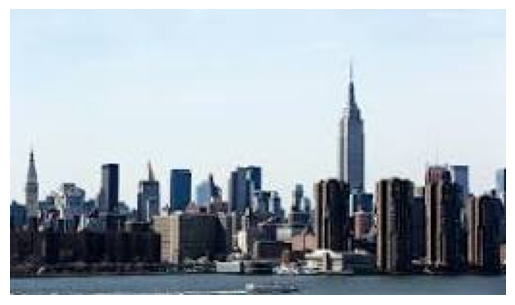

In [ ]:

import matplotlib.pyplot as plt
import PIL.Image

try:
    img = PIL.Image.open(content_path)  # या style_path
    plt.imshow(img)
    plt.axis("off")
    plt.show()
except FileNotFoundError:
    print("❌ Error: File not found! कृपया सही पथ का उपयोग करें या फाइल दोबारा अपलोड करें।")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras import models

def vgg_layers(layer_names):
    """Loads VGG19 model and extracts outputs for specified style and content layers."""
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return models.Model([vgg.input], outputs)

# Define content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create the model
num_style_layers = len(style_layers)
model = vgg_layers(style_layers + content_layers)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as kp_image

def preprocess_image(img_path):
    """Loads and preprocesses an image for VGG19 input."""
    img = kp_image.load_img(img_path, target_size=(512, 512))  # Resize image to 512x512
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

# Process content and style images
content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)

# Extract features from the model
content_features = model(content_image)[num_style_layers:]  # Content features
style_features = model(style_image)[:num_style_layers]  # Style features

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


In [ ]:
def gram_matrix(input_tensor):
    """Computes the Gram matrix for style representation."""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    num_locations = tf.shape(input_tensor)[1] * tf.shape(input_tensor)[2]
    return result / tf.cast(num_locations, tf.float32)

def style_loss(style_output, gram_target):
    """Computes the style loss by comparing the Gram matrices."""
    return tf.reduce_mean(tf.square(gram_matrix(style_output) - gram_target))

def content_loss(content_output, target):
    """Computes the content loss."""
    return tf.reduce_mean(tf.square(content_output - target))

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=5.0)

@tf.function
def train_step(image, gram_style_features, content_features):
    """Performs a single optimization step to update the stylized image."""
    with tf.GradientTape() as tape:
        outputs = model(image)
        style_outputs, content_output = (outputs[:num_style_layers], outputs[num_style_layers:])

        loss = 0
        for target, comb in zip(gram_style_features, style_outputs):
            loss += style_loss(comb, target) * (1 / num_style_layers)

        loss += content_loss(content_output[0], content_features[0]) * 1e4

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    return loss

Iteration 0: Loss 18625484800.0
Iteration 100: Loss 169683248.0
Iteration 200: Loss 99769376.0
Iteration 300: Loss 75918528.0
Iteration 400: Loss 63696496.0
Iteration 500: Loss 53602344.0
Iteration 600: Loss 46916532.0
Iteration 700: Loss 57245264.0
Iteration 800: Loss 86866792.0
Iteration 900: Loss 34413692.0


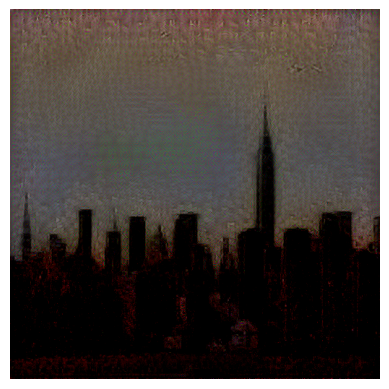

In [ ]:
content_image = tf.Variable(content_image, dtype=tf.float32)
style_outputs = model(style_image)[:num_style_layers]
gram_style_features = [gram_matrix(style) for style in style_outputs]
content_features = model(content_image)[num_style_layers:]

epochs = 1000  # Number of iterations
for i in range(epochs):
    loss = train_step(content_image, gram_style_features, content_features)
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.numpy()}")

# Display the final stylized image
final_img = np.array(content_image[0])
final_img = np.clip(final_img, 0, 255).astype('uint8')
import matplotlib.pyplot as plt
plt.imshow(final_img)
plt.axis('off')
plt.show()

In [ ]:
from google.colab import files
output_path = "stylized_image.jpg"
PIL.Image.fromarray(final_img).save(output_path)
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>